In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing  import StandardScaler

Using TensorFlow backend.


In [2]:
all_years = 6 #years that we have data from: 2019-2014
dfs = []
years = []

for i in range(all_years):
    year = 2019-i
    years.append(year)
    filename = 'HW3data/'+str(year)+'T.csv'
    dfs.append(pd.read_csv(filename))
    
#converting empty cells and whitespaces to nans
for c in dfs[0].columns: #naming convention is the same for all columns in datasets
    for df in dfs:
        df[c] = pd.to_numeric(df[c], errors = 'coerce')

In [3]:
def leap(year):
    if(year % 4 == 0):
        return True
    return False

def month(year, day):
    if(not leap(year)):
        if(day<=31): return 0
        elif(day>31 and day <= 59): return 1
        elif(day>59 and day <= 90): return 2
        elif(day>90 and day <= 120): return 3
        elif(day>120 and day <= 151): return 4
        elif(day>151 and day <= 181): return 5
        elif(day>181 and day <= 212): return 6
        elif(day>212 and day <= 243): return 7
        elif(day>243 and day <= 273): return 8
        elif(day>273 and day <= 304): return 9
        elif(day>304 and day <= 334): return 10
        elif(day>334 and day <= 365): return 11
    else:
        if(day<=31): return 0
        elif(day>31 and day <= 60): return 1
        elif(day>60 and day <= 91): return 2
        elif(day>91 and day <= 121): return 3
        elif(day>121 and day <= 152): return 4
        elif(day>152 and day <= 182): return 5
        elif(day>182 and day <= 213): return 6
        elif(day>213 and day <= 244): return 7
        elif(day>244 and day <= 274): return 8
        elif(day>274 and day <= 305): return 9
        elif(day>305 and day <= 335): return 10
        elif(day>335 and day <= 366): return 11
        

C:\Users\Dani\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
C:\Users\Dani\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


(2191, 2)
(1461, 2)


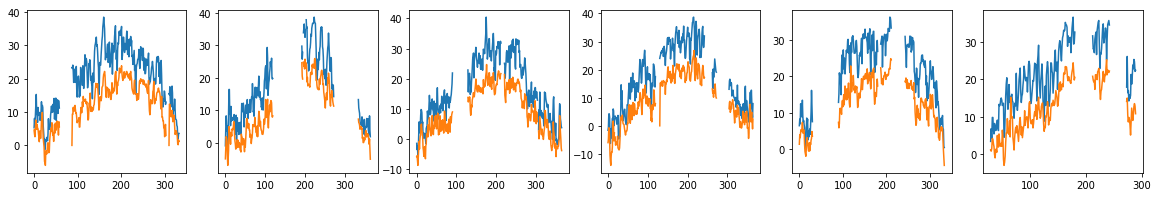

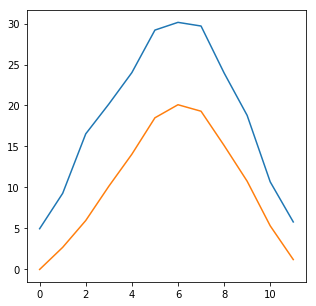

In [4]:
prev_years = 2 #prerviou years to on input
prev_days = 4 #previous days on input
years_to_predict = all_years - prev_years #years for target (train, test , valid)
  
#making a sequence of each day's min max values for every year
Ys = []
#calculating mean values for every month
monthly_means = np.zeros((12,2))
not_nan_months = np.zeros((12))

plt.figure(figsize = (20,3))

#reverse  both to start with the earliest data
dfs.reverse()
years.reverse()

saved = False
real2019 = np.zeros((1))

for df in dfs:
    y = following = df.iloc[:,0:2].to_numpy(dtype = 'float32')
    monthly_means[0] = np.nansum((monthly_means[0] , np.nanmean(following, axis = 0)), axis = 0)
    not_nan_months[0] += 1 if not np.isnan(np.nanmean(following, axis = 0)).any() else 0
    for i in range(1,12):
        following = df.iloc[:,2*i:2*i+2].to_numpy(dtype = 'float32')
        y = np.concatenate((y, following))
        monthly_means[i] = np.nansum((monthly_means[i], np.nanmean(following, axis = 0)), axis  = 0)
        not_nan_months[i] += 1 if not np.isnan(np.nanmean(following, axis = 0)).any() else 0
        #removing the 31st for 30 day long months
        if(i in [3,5,8,10]):
            y = y[:-1,:]
        #removing the appropriate days of february with consideration of leap years
        if(i == 1):
            if(not leap(years[len(Ys)])):
                y = y[:-3,:]
            else:
                y = y[:-2,:]
    Ys.append(y)
    if(not saved):
        real2019 = y
        saved = True
    plt.subplot(160+len(Ys))
    plt.plot(y)

not_nan_months = np.array((not_nan_months, not_nan_months))    
monthly_means = np.divide(monthly_means, not_nan_months.T)

plt.figure(figsize = (5,5))
plt.plot(monthly_means)

#concatenating list to numpy arrays

#all days in database
Y_all = Ys[0]
for i in range(1,len(Ys)):
    Y_all = np.concatenate((Y_all, Ys[i]))
    
#days to use for prediction
Y_predict = Ys[prev_years]
for i in range(prev_years+1,len(Ys)):
    Y_predict = np.concatenate((Y_predict, Ys[i]))

print(Y_all.shape)
print(Y_predict.shape)

In [5]:
def find_replacement(actual, repyear):
    #trying to replace with mean of the given day in for all previous years
    days_since = 0
    replacement = np.array((np.nan, np.nan)) #skipped in nanmean
    leaps = 0
    for k in range(repyear - years[0] - 1):
        days_since += 366 if leap(years[k]) else 365
        replacement = np.vstack((replacement, Y_all[actual-days_since,0:2]))
        if(leap(years[k])):
            leaps += 1
    replacement = np.nanmean(replacement, axis = 0)
    #if replacement is not available use monthly mean
    day = actual - (repyear - years[0] ) * 365 - leaps
    replacement = replacement if not np.isnan(replacement).any() else monthly_means[month(year, day)]
    return replacement

In [6]:
Xs = []

#first index to use for prediction
first_index = Y_all.shape[0] - Y_predict.shape[0]

year = years[prev_years]
day = 0

#for all y generate input from prevoius days and same days from previous years
for i in range(len(Y_predict)):
    #counting years and days
    day += 1
    if((day > 365 and not leap(year)) or (day > 366 and leap(year))) :
        day = 1
        year += 1
    #indexing
    actual = first_index+i-1
    if(np.isnan(Y_all[actual,:]).any()): 
        x = find_replacement(actual, year)
    else:
        x = Y_all[actual]
    #previous days
    for j in range(1,prev_days):
        actual -= 1
        #if not available then use mean of all previous years
        if(np.isnan(Y_all[actual,:]).any()): 
            x = np.concatenate((x, find_replacement(actual, year)))
        #if available concatenate to
        else:
            x = np.concatenate((x, Y_all[actual]))
    actual = first_index+i-1
    days_since = 0
    for j in range(prev_years):
        days_since += 366 if leap(year-j-1) else 365
        if(np.isnan(Y_all[actual-days_since,:]).any()): 
            x = np.concatenate((x, find_replacement(actual-days_since, year-j-1)))
        else:
            x = np.concatenate((x, Y_all[actual-days_since]))
    Xs.append(x)

#days to use for prediction
X_predict = Xs[0]
for i in range(1,len(Xs)):
    X_predict = np.vstack((X_predict, Xs[i]))
print(X_predict.shape)

(1461, 12)


C:\Users\Dani\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


In [7]:
#size of splits
valid_split=0.3
test_split=0.1

#permutating the data
randperm = np.random.permutation(len(X_predict))
X_predict, Y_predict = X_predict[randperm], Y_predict[randperm]

#removing nan from Y_predict
Y_unmodified = Y_predict.copy()
X_predict = X_predict[~np.isnan(Y_predict).any(axis=1)]
Y_predict = Y_predict[~np.isnan(Y_predict).any(axis=1)]

# train-validation-test sample splits
X_train = X_predict[0:int(X_predict.shape[0]*(1-valid_split-test_split))]
Y_train = Y_predict[0:int(X_predict.shape[0]*(1-valid_split-test_split))]
X_valid = X_predict[int(X_predict.shape[0]*(1-valid_split-test_split)):int(X_predict.shape[0]*(1-test_split))]
Y_valid = Y_predict[int(X_predict.shape[0]*(1-valid_split-test_split)):int(X_predict.shape[0]*(1-test_split))]
X_test  = X_predict[int(X_predict.shape[0]*(1-test_split)):]
Y_test  = Y_predict[int(X_predict.shape[0]*(1-test_split)):]

# standardization
scalerx = StandardScaler().fit(X_train)
X_train = scalerx.transform(X_train)
X_valid = scalerx.transform(X_valid)
X_test  = scalerx.transform(X_test)


scalery = StandardScaler().fit(Y_train)
Y_train = scalery.transform(Y_train)
Y_valid = scalery.transform(Y_valid)
Y_test  = scalery.transform(Y_test)


print("TRAIN mean es std:",np.mean(X_train), np.std(X_train))
print("VALID mean es std:",np.mean(X_valid), np.std(X_valid))
print("TEST mean es std:",np.mean(X_test), np.std(X_test))

TRAIN mean es std: 5.2136259437323916e-17 0.9999999999999999
VALID mean es std: -0.06780227484735843 1.0175945910548014
TEST mean es std: -0.18410526020469314 1.1040589974613075


In [8]:
model = Sequential()
model.add(Dense(10, input_shape =(X_train.shape[1],)))
model.add(Activation('sigmoid'))
model.add(Dense(20))
model.add(Activation('sigmoid'))
model.add(Dense(2))

adam = Adam(lr = 0.01)

model.compile(loss='mse', optimizer=adam)

es = EarlyStopping(patience=50, verbose=1)
mcp = ModelCheckpoint(filepath='model_temperature.hdf5', save_best_only=True, verbose=1)

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                130       
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                220       
_________________________________________________________________
activation_2 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 42        
Total params: 392
Trainable params: 392
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.fit(X_train, Y_train, validation_data = (X_valid,Y_valid), epochs = 1000, batch_size = 16, callbacks=[mcp, es])

Train on 636 samples, validate on 318 samples
Epoch 1/1000
636/636 [==============================] - 0s 157us/step - loss: 0.4562 - val_loss: 0.1814

Epoch 00001: val_loss improved from inf to 0.18139, saving model to model_temperature.hdf5
Epoch 2/1000
636/636 [==============================] - 0s 53us/step - loss: 0.1793 - val_loss: 0.1207

Epoch 00002: val_loss improved from 0.18139 to 0.12070, saving model to model_temperature.hdf5
Epoch 3/1000
636/636 [==============================] - 0s 52us/step - loss: 0.1242 - val_loss: 0.0958

Epoch 00003: val_loss improved from 0.12070 to 0.09578, saving model to model_temperature.hdf5
Epoch 4/1000
636/636 [==============================] - 0s 53us/step - loss: 0.1036 - val_loss: 0.0909

Epoch 00004: val_loss improved from 0.09578 to 0.09087, saving model to model_temperature.hdf5
Epoch 5/1000
636/636 [==============================] - 0s 53us/step - loss: 0.0907 - val_loss: 0.0830

Epoch 00005: val_loss improved from 0.09087 to 0.08298, s

636/636 [==============================] - 0s 53us/step - loss: 0.0797 - val_loss: 0.0787

Epoch 00050: val_loss did not improve from 0.07626
Epoch 51/1000
636/636 [==============================] - 0s 53us/step - loss: 0.0783 - val_loss: 0.0898

Epoch 00051: val_loss did not improve from 0.07626
Epoch 52/1000
636/636 [==============================] - 0s 55us/step - loss: 0.0794 - val_loss: 0.0784

Epoch 00052: val_loss did not improve from 0.07626
Epoch 53/1000
636/636 [==============================] - 0s 53us/step - loss: 0.0772 - val_loss: 0.0773

Epoch 00053: val_loss did not improve from 0.07626
Epoch 54/1000
636/636 [==============================] - 0s 53us/step - loss: 0.0823 - val_loss: 0.0765

Epoch 00054: val_loss did not improve from 0.07626
Epoch 55/1000
636/636 [==============================] - 0s 55us/step - loss: 0.0741 - val_loss: 0.0806

Epoch 00055: val_loss did not improve from 0.07626
Epoch 56/1000
636/636 [==============================] - 0s 53us/step - loss: 

636/636 [==============================] - ETA: 0s - loss: 0.066 - 0s 53us/step - loss: 0.0733 - val_loss: 0.0852

Epoch 00102: val_loss did not improve from 0.07541
Epoch 103/1000
636/636 [==============================] - 0s 55us/step - loss: 0.0799 - val_loss: 0.0815

Epoch 00103: val_loss did not improve from 0.07541
Epoch 104/1000
636/636 [==============================] - 0s 55us/step - loss: 0.0730 - val_loss: 0.0768

Epoch 00104: val_loss did not improve from 0.07541
Epoch 105/1000
636/636 [==============================] - 0s 55us/step - loss: 0.0745 - val_loss: 0.0775

Epoch 00105: val_loss did not improve from 0.07541
Epoch 106/1000
636/636 [==============================] - 0s 53us/step - loss: 0.0731 - val_loss: 0.0823

Epoch 00106: val_loss did not improve from 0.07541
Epoch 107/1000
636/636 [==============================] - 0s 53us/step - loss: 0.0757 - val_loss: 0.0784

Epoch 00107: val_loss did not improve from 0.07541
Epoch 108/1000
636/636 [=========================

636/636 [==============================] - 0s 55us/step - loss: 0.0703 - val_loss: 0.0772

Epoch 00154: val_loss did not improve from 0.07511
Epoch 155/1000
636/636 [==============================] - 0s 53us/step - loss: 0.0705 - val_loss: 0.0760

Epoch 00155: val_loss did not improve from 0.07511
Epoch 156/1000
636/636 [==============================] - 0s 53us/step - loss: 0.0693 - val_loss: 0.0774

Epoch 00156: val_loss did not improve from 0.07511
Epoch 157/1000
636/636 [==============================] - 0s 55us/step - loss: 0.0689 - val_loss: 0.0775

Epoch 00157: val_loss did not improve from 0.07511
Epoch 158/1000
636/636 [==============================] - 0s 53us/step - loss: 0.0692 - val_loss: 0.0781

Epoch 00158: val_loss did not improve from 0.07511
Epoch 159/1000
636/636 [==============================] - 0s 53us/step - loss: 0.0715 - val_loss: 0.0768

Epoch 00159: val_loss did not improve from 0.07511
Epoch 160/1000
636/636 [==============================] - 0s 53us/step - 

In [11]:
test_err = model.evaluate(X_test, Y_test)
print("Test MSE: ", test_err)

106/106 [==============================] - 0s 19us/step
Test MSE:  0.0910906102859749


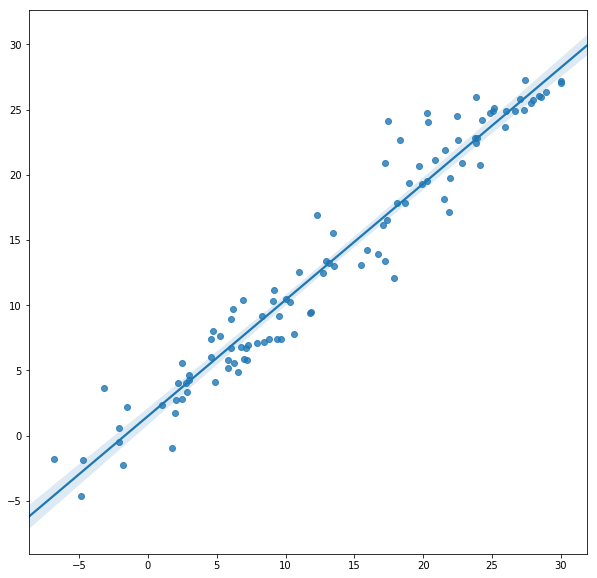

In [12]:
import seaborn as sns
preds = model.predict(X_test)
plt.figure(figsize = (10,10))
# shows correlation between expected and predicted values
sns.regplot(x=np.mean(scalery.inverse_transform(Y_test), axis = 1), y=np.mean(scalery.inverse_transform(preds), axis = 1).reshape(-1)) 

In [15]:
#use this for prediction (generates input for year, month, day, scales output)
def predict(y, m, d):
    if(y not in years):
        y = years[all_years-1]
    leaps = 0
    for year in range(y, years[all_years-1]+1):
        leaps += 1 if(leap(year)) else 0
    actual = - (years[all_years-1] - y + 1) * 365 - leaps
    for i in range(m):
        if(i in [0,2,4,6,7,9,11]):
            actual += 31
        elif(i in [3,5,8,10]):
            actual += 30
        elif(i==1 and leap(y)):
            actual += 29
        elif(i==1 and not leap(y)):
            actual += 28
    actual += (d - 1)
    if(np.isnan(Y_all[actual,:]).any()): 
        x = find_replacement(actual, y)
    else:
        x = Y_all[actual]
    for j in range(1,prev_days):
        actual -= 1
        #if not available then use mean of all previous years
        if(np.isnan(Y_all[actual,:]).any()): 
            x = np.concatenate((x, find_replacement(actual, y)))
        #if available concatenate to
        else:
            x = np.concatenate((x, Y_all[actual]))
    actual += prev_days
    days_since = 0
    for j in range(prev_years):
        days_since += 366 if leap(y-j-1) else 365
        if(np.isnan(Y_all[actual-days_since,:]).any()): 
            x = np.concatenate((x, find_replacement(actual-days_since, y-j-1)))
        else:
            x = np.concatenate((x, Y_all[actual-days_since]))
    x = np.expand_dims(x, axis=0)
    return np.mean(scalery.inverse_transform(model.predict(x)))

In [16]:
print('Predicction for 2019 october 30.: ', predict(2019, 9, 30))
print('Predicction for 2019 november 5.: ',predict(2019, 10, 6))
print('Predicction for 2019 november 26.: ',predict(2019, 10, 26))

Predicction for 2019 october 30.:  20.7901
Predicction for 2019 november 5.:  18.63046
Predicction for 2019 november 26.:  21.61474
